In [82]:
!pip install madmom

In [83]:
SCRIPT_INTRODUCTION = """
   ==================== [EDA ] ====================
Exploratory data analysis of one song of the MDB drums dataset (see https://github.com/CarlSouthall/MDBDrums for downloading it). Is it possible to visualize our different sounds? Take a sample.

It is based on the following links:
https://github.com/slychief/ismir2018_tutorial/blob/master/Part_3a_Onset_Detection.ipynb
https://github.com/CPJKU/madmom_tutorials/blob/master/onset_detection.ipynb
https://musicinformationretrieval.com/onset_detection.html

  ==================== ==================[ INFO ] ==============================
"""

import librosa
from google.colab import drive
import os,sys,re,pandas as pd,numpy as np
import glob
import logging
from sympy import Interval
import warnings
import librosa
import madmom
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import glob

plt.rcParams['figure.figsize'] = (15, 8)


Dont do drive.mount if you're not using google drive

In [84]:
ROOT_DIR = "/content/drive"

drive.mount(ROOT_DIR, force_remount=True)
#Don't forget to type My Drive before the whole path
MUSIC_DIR = os.path.join(ROOT_DIR,'My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/')
AUDIO_DIR = os.path.join(MUSIC_DIR,"audio","drum_only")
ANNOTATIONS_DIR = os.path.join(MUSIC_DIR,"annotations","class","train" )#/class/train"


Mounted at /content/drive


In [85]:
def search_correspondingpath_given_annotation(annotation_path_txt, audio_directory):
  """
  Parameters:
    annotation_path_txt: 
    audio_directory: str -> dont input path /train; just input where train,test folders are
  This function will receive an annotation_txt path and look for its corresponding .wav inside the audio_directory ; audio_directory must have train and test folders 
  audio_directory is often -> AUDIO_DIR = "/content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/audio/drum_only"
  from ESP_Pipe003_01_GenerateBarsFor3Different models.ipynb
  """
  filepath_wav = os.path.basename(annotation_path_txt).replace(".txt",".wav")
  # required preprocess 
  filepath_wav = filepath_wav.replace("_class","_Drum")

  if "test" in annotation_path_txt: #means need to go to perform the search where the ttest set is
    filepath_wav = os.path.join(audio_directory,"test",filepath_wav)
  elif "train" in annotation_path_txt:#means need to go to perform the search where the train  set is
    filepath_wav = os.path.join(audio_directory,"train",filepath_wav)
  else:
    raise ValueError("must be either in test or train , review the file")
    assert os.path.exists(filepath_wav),"The file doesn't exist , review your annotation process"
  return filepath_wav

def load_labels(annotation_path, set2df = True):
  """
  load labels given an annotation path
  """
  with open(annotation_path,"r") as f:
    labels = [x.replace("\n","").strip().split(" \t ") for x in f.readlines()]
  if set2df:
    labels = pd.DataFrame(labels, columns = ["onset_time","drum_type"])
  return labels


In [86]:

wav_files_path = glob.glob(AUDIO_DIR+"/*.wav")
annotation_files_path = glob.glob(ANNOTATIONS_DIR+"/*.txt")
annotation_path = annotation_files_path[2]
annotation_path

'/content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/annotations/class/train/MusicDelta_Rock_class.txt'

In [87]:
audio_path = search_correspondingpath_given_annotation(annotation_path, AUDIO_DIR)
print("[INFO] Songpath to analyze:", audio_path)
df_annotations = load_labels(annotation_path)
# save annotations into a list
annotations = df_annotations["onset_time"].tolist()
df_annotations.head(10)

[INFO] Songpath to analyze: /content/drive/My Drive/Maestria DM y KDD/Especializacion tesis/MDBDrums/MDB Drums/audio/drum_only/train/MusicDelta_Rock_Drum.wav


,onset_time,drum_type
0,0.000000,KD
1,0.020000,HH
2,0.280000,HH
3,0.528254,SD
4,0.550000,HH
5,0.830000,HH
6,1.062313,KD
7,1.090000,HH
8,1.360000,HH
9,1.619592,SD


In [88]:
#time domain representation
signal = madmom.audio.Signal(audio_path, sample_rate = 22050)
signal

Signal([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [89]:
signal.sample_rate

22050

Perform a few tweaks to our annotation dataset:

In [90]:
df_annotations["onset_time"] = df_annotations["onset_time"].astype(float)
df_annotations["onset_samples"] = (df_annotations["onset_time"]*signal.sample_rate).astype(int)
df_annotations["onset_samples"].head()
df_annotations["drum_type"] = df_annotations["drum_type"].str.strip()

Take the first 5 seconds for our purpose of analyzing a short rythm: 

In [91]:
# just 5 seconds
df_annotations_5sec = df_annotations[df_annotations["onset_time"] < 5].reset_index(drop = True)
annotations_5sec = df_annotations_5sec["onset_time"].tolist()
signal_5sec = madmom.audio.Signal(audio_path, sample_rate = 22050, start=0, stop = 5)
print(signal.shape)
print(signal_5sec.shape)

(288660,)
(110250,)


# PLOT first 5 seconds of the signal 

In [92]:


# this is jsut for controlling font sizes
SMALL_SIZE = 24
MEDIUM_SIZE = 30
BIGGER_SIZE = 36
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [93]:
df_annotations_5sec.head(10)

,onset_time,drum_type,onset_samples
0,0.000000,KD,0
1,0.020000,HH,441
2,0.280000,HH,6174
3,0.528254,SD,11648
4,0.550000,HH,12127
5,0.830000,HH,18301
6,1.062313,KD,23424
7,1.090000,HH,24034
8,1.360000,HH,29988
9,1.619592,SD,35712


Take a look at the next figure, you'll see onsets marked with a dotted line; and the signal with a blue line. You probably noticed that when there's a new onset, there's a huge increase in the absolute value of the signal's amplitude. That increase is greater for the SnareDrum(SD) (ie onset number 3 starting from 0, see the table above) than for KickDrum(KD) (first onset in the table). Also the sound with the lowest amplitude in absolute value, is the HiHat (HH), for example, the onset number 2, in the second 0.02.

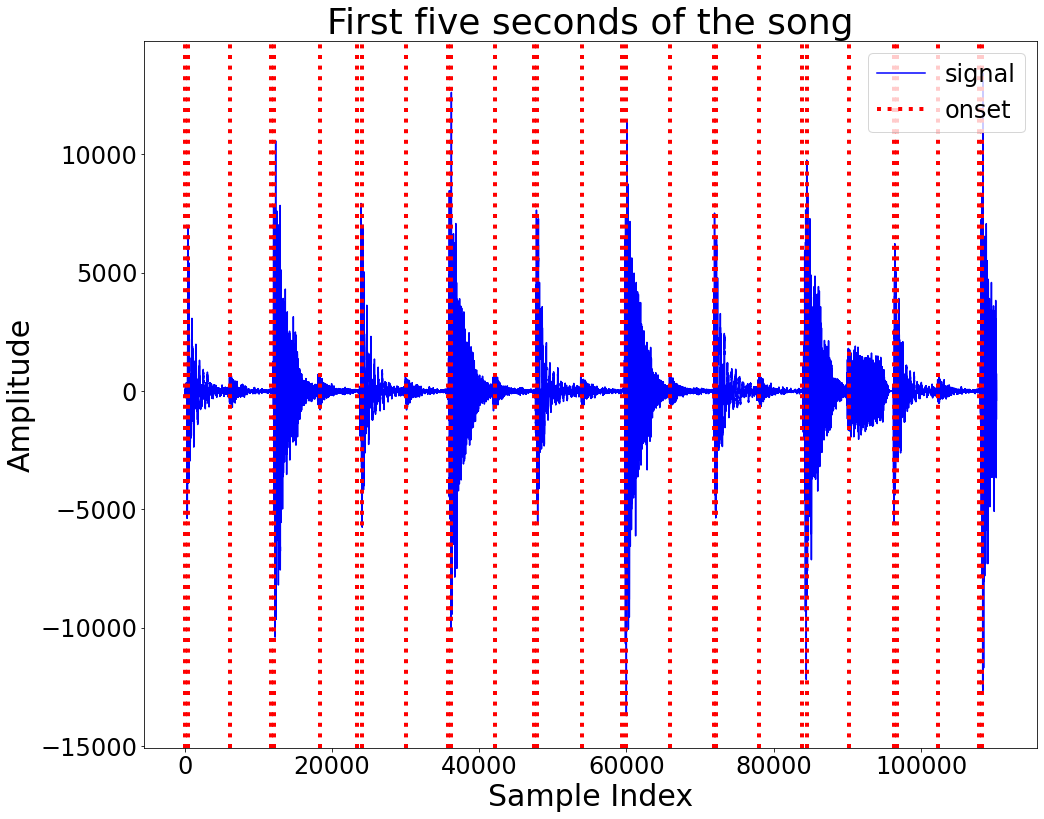

In [94]:
plt.figure(figsize = (16,13) )
plt.plot(signal_5sec,color="blue")
# Spanish
# plt.title("Primeros cinco segundos de la canción (sin distinguir por onsets)",size=30)
# plt.xlabel('Número de muestra')
# plt.ylabel('Amplitud')
# English
plt.title("First five seconds of the song",size=36)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

n_annotations = len(df_annotations_5sec)
for ann_idx in range(n_annotations):
    drum_type = df_annotations_5sec.loc[ann_idx,"drum_type"]
    drum_type = drum_type.strip()
    onset_time = df_annotations_5sec.loc[ann_idx,"onset_time"]
    plt.axvline(x=onset_time * signal_5sec.sample_rate, color='red', linestyle='dotted', linewidth=4)

plt.legend(["signal","onset"], loc='upper right')


If at this point you ask yourself why the xaxis has not the "time", let's clarify this: Our sampling_rate is 22050 (how much samples you have per second in the song). 22050samples = 1second, so for knowing which time is an onset number 40000 just do 40000/22050 = 1.81 --> that onset is occuring at the second 1.814 

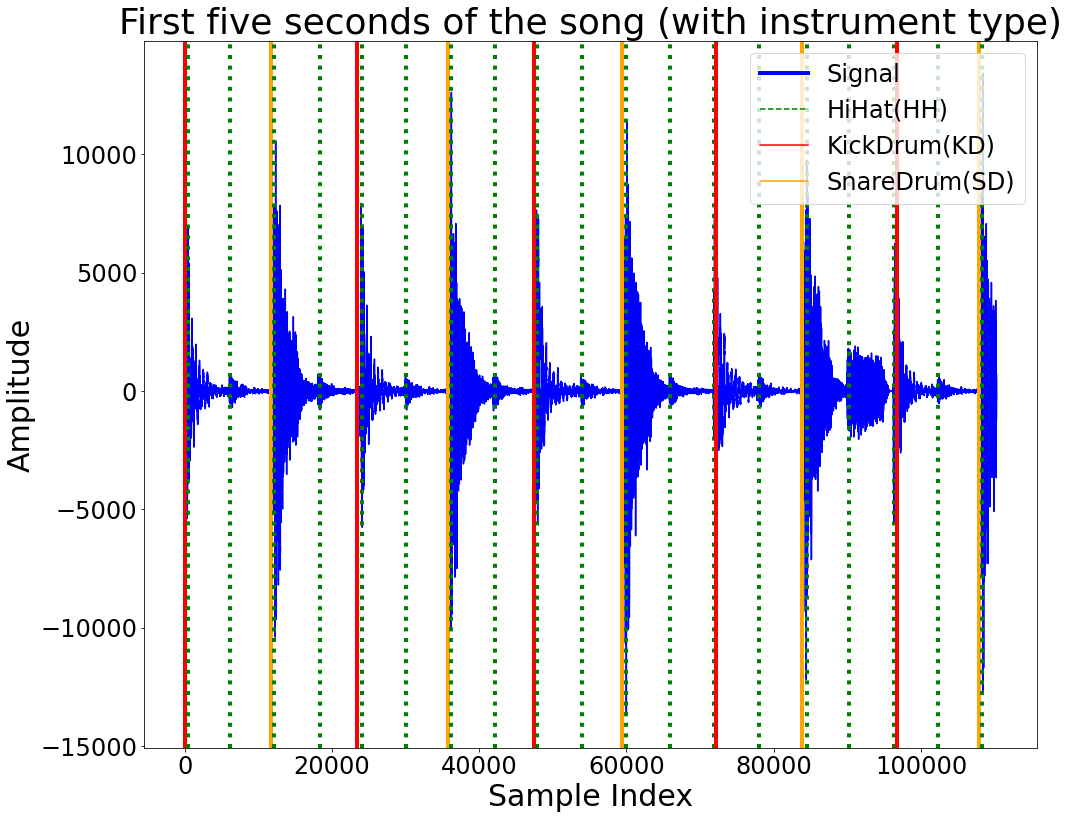

In [95]:
plt.figure(figsize = (16,13) )
plt.plot(signal_5sec,color="blue")
# Spanish
# plt.title("Primeros cinco segundos de la canción (distinguiendo el tipo de instrumento)",size=30)
# plt.xlabel('Número de muestra')
# plt.ylabel('Amplitud')
# English
plt.title("First five seconds of the song (with instrument type)",size=36)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
n_annotations = len(df_annotations_5sec)
for ann_idx in range(n_annotations):
    drum_type = df_annotations_5sec.loc[ann_idx,"drum_type"]
    drum_type = drum_type.strip()
    onset_time = df_annotations_5sec.loc[ann_idx,"onset_time"]
    if drum_type == "HH":
      plt.axvline(x=onset_time * signal_5sec.sample_rate, color='green', linestyle='dotted', linewidth=4) 
    elif drum_type == "KD":
      plt.axvline(x=onset_time * signal_5sec.sample_rate, color='red', linestyle='solid', linewidth=4)
    elif drum_type == "SD":
      plt.axvline(x=onset_time * signal_5sec.sample_rate, color='orange', linestyle='solid', linewidth=4)
    else:
      print(drum_type)
      plt.axvline(x=onset_time * signal_5sec.sample_rate, color='black', linestyle='dotted', linewidth=4)



from matplotlib.patches import Patch
from matplotlib.lines import Line2D



legend_elements = [Line2D([0], [0], linestyle="solid",color='blue', lw=4, label='Signal'),
                   Line2D([0], [0], linestyle="dashed", color='green', label='HiHat(HH)' ),
                   Line2D([0], [0], linestyle="solid", color='red', label='KickDrum(KD)' ),
                   Line2D([0], [0], linestyle="solid", color='orange', label='SnareDrum(SD)' )]

plt.legend(handles=legend_elements,loc="upper right")


# Now let's compute the STFT and see if we can distinguish the sounds in the frequency domain 

In [96]:
# stft representation (time-frequency domain)
# this fps and frame size usually work well for many tasks, adjust this if required
FPS = 100
FRAME_SIZE = 2048
spec = madmom.audio.Spectrogram(signal_5sec, fps = FPS , frame_size  = FRAME_SIZE)

By looking at the following figure, you'll see that:

1) HiHat(HH) solo has less energy than KickDrum(KD) or SnareDrum(SD); so it can be distinguished between the other two.

2) SnareDrum (SD) has more energy across higher frequencies than KickDrum(KD), it also last longer (the decrease in the sound of KD goes at a faaster speed than in the SD). So we can distinguish between KD & SD.

3) So far we didn't present KD or SD solo, but KD+HH or SD+HH (ocurring at the same time). We would have to analyze later if those can be distinguished ( KD vs KD+HH)

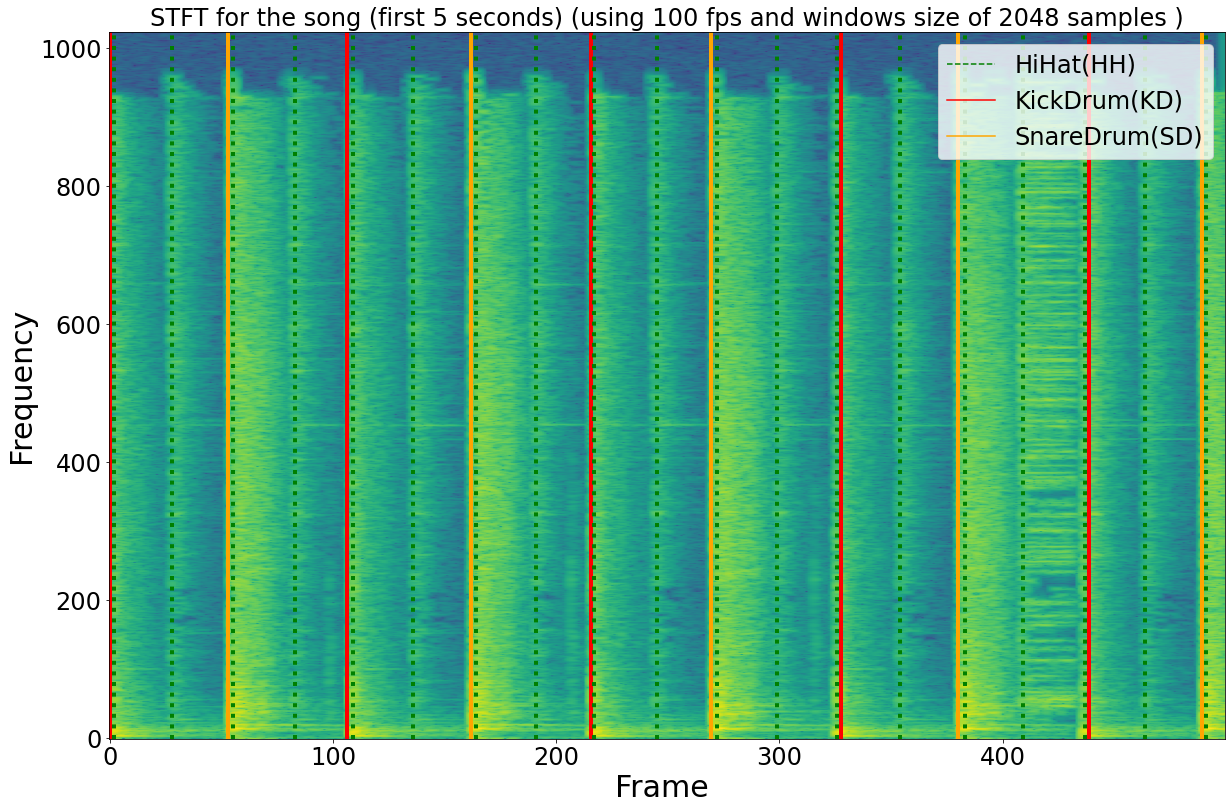

In [97]:
plt.figure(figsize = (20,13) )
plt.imshow(np.log(spec).T[:1024], origin='lower', aspect='auto')
# Spanish
# plt.title(f"STFT para los primeros cinco segundos de la canción (utilizando {FPS} fps y ventana de {FRAME_SIZE} muestras )")
# plt.xlabel('Frame ')
# plt.ylabel('Frecuencia')
# English
plt.title(f"STFT for the song (first 5 seconds) (using {FPS} fps and windows size of {FRAME_SIZE} samples )")
plt.xlabel('Frame ')
plt.ylabel('Frequency')
n_annotations = len(df_annotations_5sec)
for ann_idx in range(n_annotations):
    drum_type = df_annotations_5sec.loc[ann_idx,"drum_type"]
    drum_type = drum_type.strip()
    onset_time = df_annotations_5sec.loc[ann_idx,"onset_time"]
    if drum_type == "HH":
      plt.axvline(x=onset_time * FPS, color='green', linestyle='dotted', linewidth=4) 
    elif drum_type == "KD":
      plt.axvline(x=onset_time * FPS, color='red', linestyle='solid', linewidth=4)
    elif drum_type == "SD":
      plt.axvline(x=onset_time * FPS, color='orange', linestyle='solid', linewidth=4)
    else:
      print(drum_type)
      plt.axvline(x=onset_time * FPS, color='black', linestyle=':', linewidth=2)

legend_elements = [Line2D([0], [0], linestyle="dashed", color='green', label='HiHat(HH)' ),
                   Line2D([0], [0], linestyle="solid", color='red', label='KickDrum(KD)' ),
                   Line2D([0], [0], linestyle="solid", color='orange', label='SnareDrum(SD)' )]
plt.legend(handles=legend_elements,loc="upper right")

In [98]:
# Filtering /It is furthermore advantageous to filter the spectrogram with a filter of (semi-)logarithmic spacing, e.g. Mel filtering.
filt_spec = madmom.audio.FilteredSpectrogram(spec)
log_filt_spec = madmom.audio.LogarithmicSpectrogram(filt_spec)
log_filt_spec.shape

(500, 84)

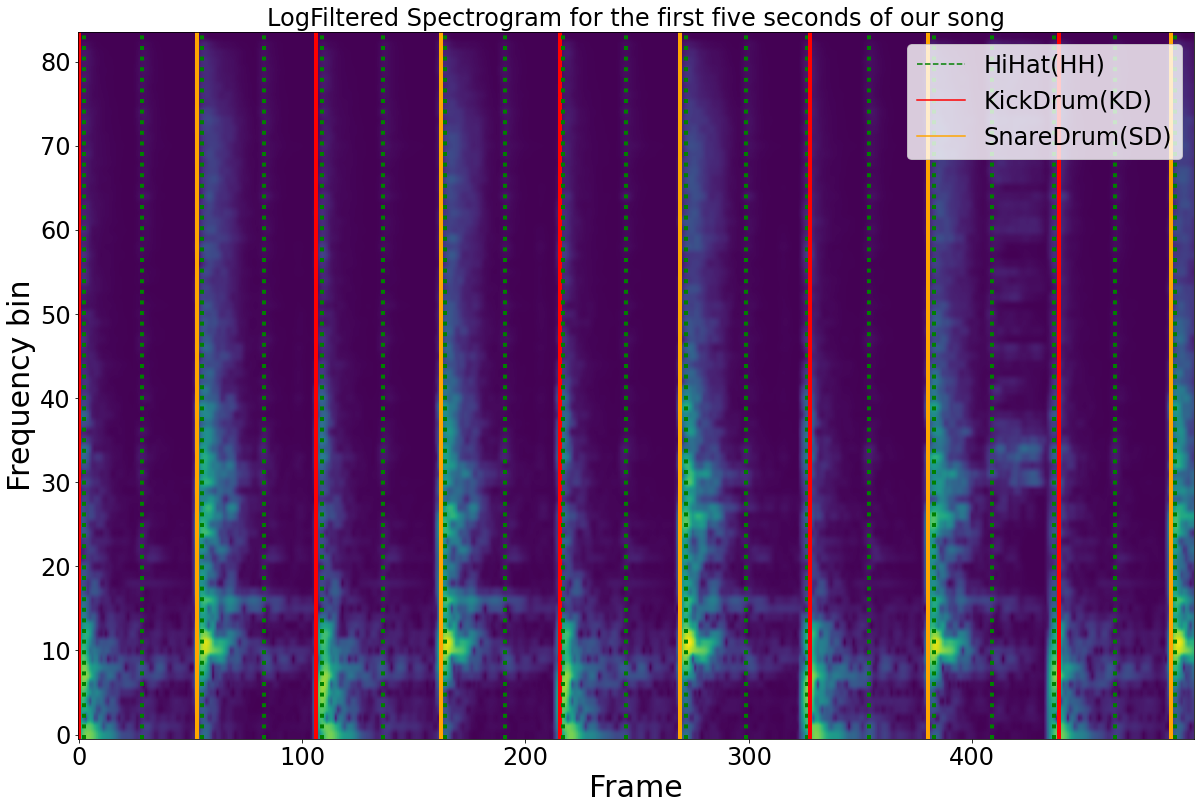

In [99]:

plt.figure(figsize = (20,13)  )
plt.imshow(log_filt_spec.T, origin='lower', aspect='auto')

# It is very clear to see the difference of energy and where it is located; for KD is mostly on the bass; for SD tend to be concentrated in the middle; and for HH is on the middle but the sound is much more soft
# English
plt.title("LogFiltered Spectrogram for the first five seconds of our song")
plt.ylabel('Frequency bin')
plt.xlabel('Frame')
# Spanish
# plt.title(f"STFT-LogFiltered para los primeros cinco segundos de la canción (utilizando {FPS} fps y ventana de {FRAME_SIZE} muestras )")
# plt.xlabel('Frame ')
# plt.ylabel('Frecuencia (bin)')
n_annotations = len(df_annotations_5sec)
for ann_idx in range(n_annotations):
    drum_type = df_annotations_5sec.loc[ann_idx,"drum_type"]
    drum_type = drum_type.strip()
    onset_time = df_annotations_5sec.loc[ann_idx,"onset_time"]
    if drum_type == "HH":
      plt.axvline(x=onset_time * FPS, color='green', linestyle='dotted', linewidth=4) 
    elif drum_type == "KD":
      plt.axvline(x=onset_time * FPS, color='red', linestyle='solid', linewidth=4)
    elif drum_type == "SD":
      plt.axvline(x=onset_time * FPS, color='orange', linestyle='solid', linewidth=4)
    else:
      print(drum_type)
      plt.axvline(x=onset_time * FPS, color='black', linestyle=':', linewidth=2)

legend_elements = [Line2D([0], [0], linestyle="dashed", color='green', label='HiHat(HH)' ),
                   Line2D([0], [0], linestyle="solid", color='red', label='KickDrum(KD)' ),
                   Line2D([0], [0], linestyle="solid", color='orange', label='SnareDrum(SD)' )]
plt.legend(handles=legend_elements,loc="upper right")